In [8]:
from hierarchical_chunker_utilities_GPT4 import *

In [9]:
from collections import defaultdict, deque
from itertools import combinations
from typing import Any, Dict, List, Optional, Sequence

def normalized_node_size_pairs(
    root: Any,
    tokens: Optional[Sequence] = None,
    include_indices: bool = False,
) -> Dict[str, Any]:
    """
    For each level L, consider all unordered pairs of nodes at that level.
    For each pair (a,b), compute (value[a] * value[b]) / N^2 and bin it under
    the level of their least common ancestor (L_LCA).

    Returns:
      {
        'normalized_pair_by_level_and_lca': List[Dict[int, List[float]]],
        'pair_counts_by_level_and_lca':    List[Dict[int, int]],
        # optional:
        'pairs_with_indices_by_level_and_lca': List[Dict[int, List[Tuple[Tuple[int,int], float]]]]
      }

    Access pattern:
      corr['normalized_pair_by_level_and_lca'][L][L_LCA] -> list of length m,
      where m is the number of unordered pairs at level L with LCA at L_LCA.
    """
    def nodes_by_level(root: Any) -> List[List[Any]]:
        levels: defaultdict[int, List[Any]] = defaultdict(list)
        q = deque([(root, 0)])
        while q:
            node, lvl = q.popleft()
            levels[lvl].append(node)
            for ch in getattr(node, 'children', []):
                q.append((ch, lvl + 1))
        max_level = max(levels.keys(), default=-1)
        return [levels[i] for i in range(max_level + 1)]

    def build_parent_and_depth(root: Any):
        parent = {root: None}
        depth = {root: 0}
        q = deque([root])
        while q:
            node = q.popleft()
            d = depth[node]
            for ch in getattr(node, 'children', []):
                parent[ch] = node
                depth[ch] = d + 1
                q.append(ch)
        return parent, depth

    # Determine N for normalization
    if tokens is not None:
        N = len(tokens)
    else:
        v = getattr(root, 'value', None)
        N = v if isinstance(v, (int, float)) and v > 0 else None
    if not N:
        raise ValueError("Normalization requires N; pass `tokens` or ensure `root.value` is a positive number.")
    inv_N2 = 1.0 / (N * N)

    parent, depth = build_parent_and_depth(root)
    levels = nodes_by_level(root)

    result: Dict[str, Any] = {
        'normalized_pair_by_level_and_lca': [],
        'pair_counts_by_level_and_lca': [],
    }
    if include_indices:
        result['pairs_with_indices_by_level_and_lca'] = []

    for L, nodes in enumerate(levels):
        # Keep only nodes with numeric values
        vals = {n: getattr(n, 'value', None) for n in nodes}
        level_nodes = [n for n in nodes if isinstance(vals[n], (int, float))]

        bins: Dict[int, List[float]] = defaultdict(list)
        counts: Dict[int, int] = defaultdict(int)
        idx_bins: Dict[int, List] = defaultdict(list) if include_indices else {}

        # indices within this level, for optional traceability
        idx_map = {n: i for i, n in enumerate(level_nodes)}

        for a, b in combinations(level_nodes, 2):
            # Find LCA (same depth ⇒ lockstep ascent)
            x, y = a, b
            while x is not y:
                x = parent[x]
                y = parent[y]
            lca_level = depth[x]

            prod_norm = (vals[a] * vals[b]) * inv_N2
            bins[lca_level].append(prod_norm)
            counts[lca_level] += 1
            if include_indices:
                idx_bins[lca_level].append(((idx_map[a], idx_map[b]), prod_norm))

        result['normalized_pair_by_level_and_lca'].append(dict(bins))
        result['pair_counts_by_level_and_lca'].append(dict(counts))
        if include_indices:
            result['pairs_with_indices_by_level_and_lca'].append(dict(idx_bins))

    return result


In [10]:
def tree_analysis_with_corr(
    results_dir: str,
    model: str,
    # *,
    # encoding_name: str = "cl100k_base"
) -> Dict[str, Dict[str, Any]]:
    """
    For every `*_result.json` in `results_dir`, rebuild the Node tree,
    compute its statistics, and return an *ordered* dict mapping:

        "<story_name>" → {
            "root": <Node>,
            "num_tokens": int,
            "chunk_sizes": List[List[int]],
            "distribution": {"dist": List[int], "bin_edges": List[float]},
            "nodes_per_level": List[int],
            "branching_ratios": List[List[int]],
            "partition": <original partition data>
            "correlation": {
                "normalized_pair_by_level_and_lca": corr.get("normalized_pair_by_level_and_lca", []),
                "pair_counts_by_level_and_lca": corr.get("pair_counts_by_level_and_lca", []),
            }
        }

    The dict is ordered by ascending `num_tokens`.
    """
    # prepare tokenizer
    encoding = tiktoken.get_encoding("cl100k_base")

    # first collect everything unsorted
    all_stats: Dict[str, Dict[str, Any]] = {}

    for fname in sorted(os.listdir(results_dir)):
        if not fname.endswith("_result.json"):
            continue

        story_name = fname[:-len("_result.json")]
        path = os.path.join(results_dir, fname)
        with open(path, "r", encoding="utf-8") as f:
            result = json.load(f)

        text      = result["original_text"]
        partition = result["partition"]
        tokens    = result["tokens"]

        # rebuild the tree
        token_ids   = encoding.encode(text)
        root        = build_token_tree(partition, iter(token_ids), encoding)

        # compute stats
        chunk_sizes  = chunk_sizes_per_level(root)
        dist, bins   = dist_per_level(chunk_sizes)
        Cs           = nodes_per_level(root)
        branches     = branching_ratios_per_level(root)
        # NEW: correlation by LCA, normalized by N^2
        corr = normalized_node_size_pairs(root, tokens=tokens)
        
        all_stats[story_name] = {
            "num_tokens": len(tokens),
            "chunk_sizes": chunk_sizes,
            "distribution": {
                "dist": dist,
                "bin_edges": bins
            },
            "nodes_per_level": Cs,
            "branching_ratios": branches,
            "partition": partition,
            # NEW block:
            "correlation": {
                "normalized_pair_by_level_and_lca": corr.get("normalized_pair_by_level_and_lca", []),
                "pair_counts_by_level_and_lca": corr.get("pair_counts_by_level_and_lca", []),
            }
        }

    # now sort by num_tokens and build a new dict in that order
    sorted_stats = dict(
        sorted(
            all_stats.items(),
            key=lambda item: item[1]["num_tokens"]
        )
    )

    return sorted_stats

In [11]:
dr          = os.getcwd()
results_dir = os.path.join(dr, "data", "labov_trees", "k=4")
stats_all = tree_analysis_with_corr(results_dir, model='gpt-4o')
print(f"Analyzed {len(stats_all)} trees.")

for story_name, info in stats_all.items():
    print(f"{story_name}: {info['num_tokens']} tokens")

stats_all['youngest'].keys()

Analyzed 26 trees.
Shambaugh: 134 tokens
Boyscout: 169 tokens
Schissel: 183 tokens
schissel_v1-pool: 189 tokens
Tarentino: 198 tokens
Dalphonso: 228 tokens
CI: 282 tokens
DAlmaggio: 300 tokens
triplett_v1-rookie: 305 tokens
Triplett: 306 tokens
Laidlaw: 308 tokens
Williams: 331 tokens
McCaffrey: 332 tokens
Guyton: 349 tokens
Hawkins: 497 tokens
Furlow: 544 tokens
hester_v1-park: 571 tokens
Hester: 639 tokens
Adamo: 741 tokens
doSomething: 805 tokens
bear: 1180 tokens
Stein: 1756 tokens
Norman: 1869 tokens
Knott: 1926 tokens
Costa: 2311 tokens
youngest: 2331 tokens


dict_keys(['num_tokens', 'chunk_sizes', 'distribution', 'nodes_per_level', 'branching_ratios', 'partition', 'correlation'])

In [12]:
stats_all['youngest']['correlation']['pair_counts_by_level_and_lca'][6]

{5: 503, 3: 6979, 0: 166823, 1: 89910, 2: 27036, 4: 1744}

In [13]:
from collections import defaultdict
from typing import Any, Dict, List

def average_correlations_across_stories(stats: Dict[str, Dict[str, Any]]) -> Dict[str, Any]:
    """
    Aggregate across stories:
      - For each level L and each LCA level, pool all normalized pair products
        (from stats[story]['correlation']['normalized_pair_by_level_and_lca'][L][L_LCA])
      - Compute the average within each (L, L_LCA) bin across ALL pooled pairs.

    Returns:
      {
        'avg_by_level_and_lca':                 List[Dict[int, float]],
        'total_pair_counts_by_level_and_lca':   List[Dict[int, int]],
      }

    Access pattern:
      result['avg_by_level_and_lca'][L][L_LCA] -> averaged normalized correlation
      result['total_pair_counts_by_level_and_lca'][L][L_LCA] -> total # pooled pairs used
    """
    # Determine maximum number of levels across all stories
    max_levels = 0
    for _, info in stats.items():
        corr_arr = info.get("correlation", {}).get("normalized_pair_by_level_and_lca", [])
        if isinstance(corr_arr, list):
            max_levels = max(max_levels, len(corr_arr))

    # Aggregators
    sums_per_L: List[defaultdict[int, float]]  = [defaultdict(float) for _ in range(max_levels)]
    cnts_per_L: List[defaultdict[int, int]]    = [defaultdict(int)   for _ in range(max_levels)]

    # Pool all normalized pairs across stories
    for story_name, info in stats.items():
        corr_block = info.get("correlation", {})
        corr_arr   = corr_block.get("normalized_pair_by_level_and_lca", [])
        if not isinstance(corr_arr, list):
            continue

        for L, lca_dict in enumerate(corr_arr):
            if not isinstance(lca_dict, dict):
                continue
            for lca_level, vals in lca_dict.items():
                if not vals:
                    continue
                # Accumulate sum and count; ignore non-numeric entries defensively
                s = 0.0
                c = 0
                for v in vals:
                    if isinstance(v, (int, float)):
                        s += float(v)
                        c += 1
                if c:
                    sums_per_L[L][lca_level] += s
                    cnts_per_L[L][lca_level] += c

    # Compute averages
    avg_by_level_and_lca: List[Dict[int, float]] = []
    total_pair_counts_by_level_and_lca: List[Dict[int, int]] = []

    for L in range(max_levels):
        avg_dict: Dict[int, float] = {}
        cnt_dict: Dict[int, int] = {}
        for lca_level, total_c in cnts_per_L[L].items():
            if total_c > 0:
                avg_dict[lca_level] = sums_per_L[L][lca_level] / total_c
                cnt_dict[lca_level] = total_c
        avg_by_level_and_lca.append(avg_dict)
        total_pair_counts_by_level_and_lca.append(cnt_dict)

    return {
        "avg_by_level_and_lca": avg_by_level_and_lca,
        "total_pair_counts_by_level_and_lca": total_pair_counts_by_level_and_lca,
    }


In [14]:
corr_result = average_correlations_across_stories(stats_all)

L = 1
L_LCA = 0

# Example access:
# Averaged correlation for level L and LCA level k:
avg_corr = corr_result['avg_by_level_and_lca'][L].get(L_LCA)

# How many total pairs contributed to that average (pooled across all stories):
m_corr = corr_result['total_pair_counts_by_level_and_lca'][L].get(L_LCA, 0)

print(m_corr)

156


In [18]:
import matplotlib.pyplot as plt
import matplotlib
# Set Matplotlib parameters
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20


def normalized_corr_formula(L, ell, K):
    num = 2**(ell - 1)
    denom = K**(2*(L-ell)) * (K*(K+1))**ell 
    return num / denom

def plot_avg_corr_subplots(result, L_min=2, L_max=9, include_theory=True, pad_factor=1.15):
    """
    result: output of average_correlations_across_stories(stats_all)
            with key 'avg_by_level_and_lca' -> List[Dict[int, float]]

    Creates a 2x4 grid for L in [2..9], plotting avg correlation vs (L - ℓ),
    with ℓ = LCA + 1. Each subplot's y-limits adapt to its own data and uses log-scale.
    """
    avg = result.get('avg_by_level_and_lca', [])
    if not isinstance(avg, list) or not avg:
        raise ValueError("result['avg_by_level_and_lca'] missing or empty")

    # Cap L_max to available levels
    L_max = min(L_max, len(avg) - 1)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # no sharey
    axes = axes.ravel()

    for i, L in enumerate(range(L_min, L_max + 1)):
        ax = axes[i]
        lca_map = avg[L] if L < len(avg) else {}

        # Build (x = L - ℓ, y = avg), with ℓ = LCA + 1  ==>  x = L - LCA - 1
        points = []
        for lca_level, y in lca_map.items():
            if not isinstance(y, (int, float)):
                continue
            x = L - (lca_level + 1)
            if x >= 0 and y is not None and y > 0:
                points.append((x, float(y)))

        points.sort(key=lambda t: t[0])

        ax.set_yscale('log')

        if points:
            xs, ys = zip(*points)
            y_th = [normalized_corr_formula(L, L - x, K=4) for x in xs]
            ax.plot(xs, ys, marker='o')
            if include_theory:
                ax.plot(xs, y_th, linestyle='--',color='r')

            # Compute adaptive y-lims in log space, with padding
            y_min, y_max = min(ys), max(ys)
            if y_min <= 0:
                # Shouldn't happen due to filtering, but guard anyway
                ys_pos = [v for v in ys if v > 0]
                if not ys_pos:
                    ax.text(0.5, 0.5, 'no valid data', ha='center', va='center', transform=ax.transAxes)
                    continue
                y_min, y_max = min(ys_pos), max(ys_pos)

            if y_min == y_max:
                # Single-valued: widen multiplicatively to make a visible range on log scale
                y_min = y_min / 1.5
                y_max = y_max * 1.5
            else:
                y_min = y_min / pad_factor
                y_max = y_max * pad_factor

            # Ensure strictly positive lower bound for log scale
            if y_min <= 0:
                y_min = min(ys) / pad_factor if min(ys) > 0 else 1e-12

            if not include_theory:
                ax.set_ylim(y_min, y_max)
        else:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center', transform=ax.transAxes)

        ax.set_title(f'Level L = {L}')
        ax.set_xlabel('L - ℓ')
        if i % 4 == 0:
            ax.set_ylabel('C(L - ℓ)')

    # Hide unused panels if fewer than 8 levels available
    used = (L_max - L_min + 1)
    for j in range(used, 8):
        axes[j].axis('off')

    fig.suptitle('Average normalized correlation vs. distance (L - ℓ)')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


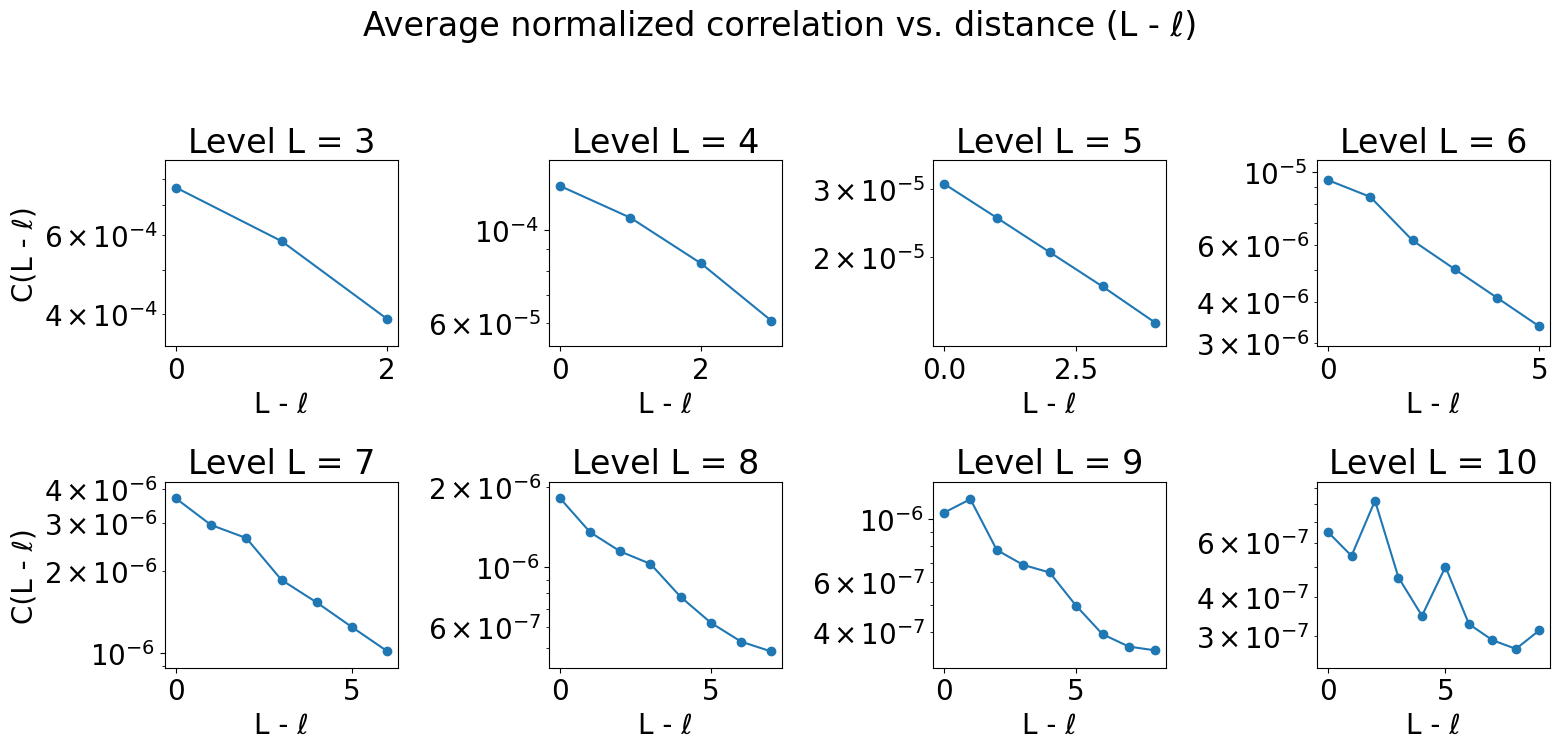

In [19]:
# Example:
fig = plot_avg_corr_subplots(corr_result, L_min=3, L_max=10, include_theory=False)
plt.show()

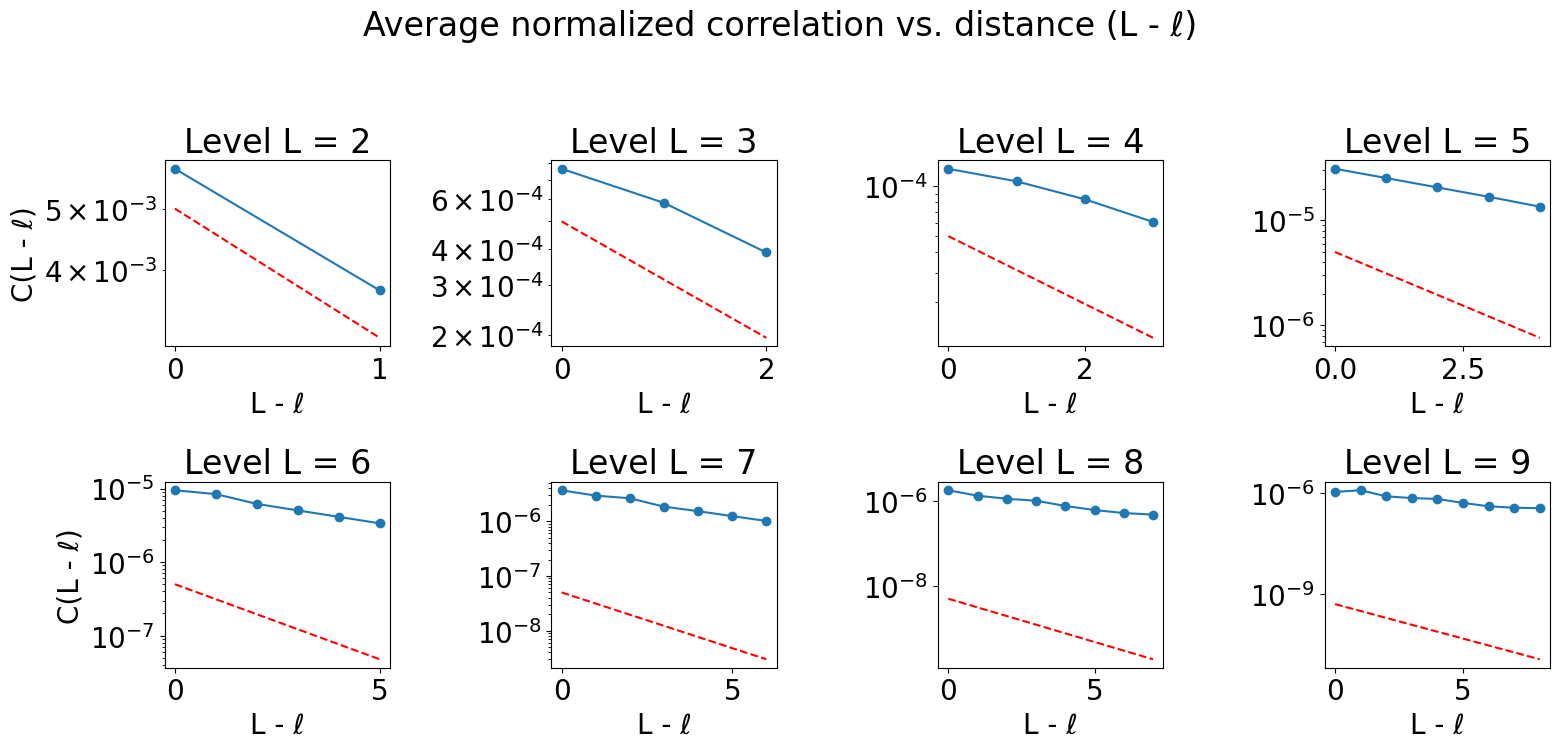

In [20]:
# Example:
fig = plot_avg_corr_subplots(corr_result, include_theory=True)
plt.show()

### Verify by hand with a single story

In [ ]:
dr          = os.getcwd()
results_dir = os.path.join(dr, "data", "labov_trees", "k=4")

story_name = "Boyscout_result.json"
path = os.path.join(results_dir, story_name)

with open(path, "r", encoding="utf-8") as f:
    result = json.load(f)

encoding = tiktoken.get_encoding("cl100k_base")
text      = result["original_text"]
partition = result["partition"]
tokens    = result["tokens"]

# rebuild the tree
token_ids   = encoding.encode(text)
root        = build_token_tree(partition, iter(token_ids), encoding)

In [23]:
chunk_sizes = chunk_sizes_per_level(root)   # list[list[int]] per level
Cs          = nodes_per_level(root)         # list[int] counts per level

# Compute correlation; tokens is optional, but pass it if you want the N^2 normalization:
corr = normalized_node_size_pairs(root, tokens=tokens)


### Verify explicitly the 1st level chunk size products

In [25]:
chunk_sizes[1]

[11, 29, 46, 83]

In [26]:
corr['normalized_pair_by_level_and_lca'][1]

{0: [0.011169076713000246,
  0.017716466510276252,
  0.03196666783375932,
  0.046707048072546484,
  0.08427576065263821,
  0.13367879275935718]}

In [36]:
N = len(tokens)
print(N)

prod = []
for i in range(len(chunk_sizes[1])):
    for j in range(i+1, len(chunk_sizes[1])):
        prod.append(chunk_sizes[1][i] * chunk_sizes[1][j])

norm_prod = np.array(prod) / (N**2)
print(norm_prod)


169
[0.01116908 0.01771647 0.03196667 0.04670705 0.08427576 0.13367879]


### Look at how many pairs there are given a level

In [30]:
corr['pair_counts_by_level_and_lca']

[{},
 {0: 6},
 {1: 18, 0: 73},
 {2: 33, 1: 131, 0: 502},
 {3: 51, 1: 596, 0: 1840, 2: 141},
 {4: 54, 1: 1240, 0: 3114, 2: 331, 3: 112},
 {5: 29, 2: 184, 1: 604, 0: 732, 3: 80, 4: 24},
 {6: 9, 1: 40, 0: 80, 2: 12, 3: 12},
 {7: 2, 0: 4}]

Text(0, 0.5, 'Pair Count')

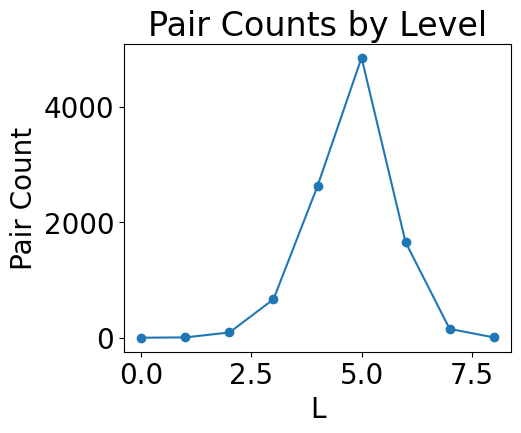

In [34]:
pairs_by_level = [sum(d.values()) for d in corr['pair_counts_by_level_and_lca']] 

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(range(len(pairs_by_level)), pairs_by_level, marker='o')
ax.set_title("Pair Counts by Level")
ax.set_xlabel("L")
ax.set_ylabel("Pair Count")

### Verify explicitly the 2nd level chunk size products 

In [52]:
from collections import deque
from typing import Any, List

def _nodes_at_level(root: Any, target_level: int) -> List[Any]:
    """
    Return the flat list of nodes at `target_level`.
    """
    if target_level < 0:
        return []
    if target_level == 0:
        return [root]

    out: List[Any] = []
    q = deque([(root, 0)])
    while q:
        node, level = q.popleft()
        if level == target_level:
            out.append(node)
            # do not enqueue children once we've reached target level
            continue
        if level < target_level:
            for ch in getattr(node, 'children', []):
                q.append((ch, level + 1))
    return out

def nested_children_nodes_at_level(root: Any, L: int) -> List[List[Any]]:
    """
    Return a nested list of the nodes at depth `L`, grouped by their parent at depth `L-1`.

    Examples:
      L = 0 -> [[root]]
      L = 1 -> [[child_0, child_1, ...]]
      L = 2 -> [[gc_of_child_0, ...], [gc_of_child_1, ...], ...]

    If `L` is deeper than the tree, returns [].
    Parents that are leaves (no children) contribute an empty list, preserving parent alignment.
    """
    if L < 0:
        raise ValueError("L must be >= 0")

    if L == 0:
        return [[root]]

    parents = _nodes_at_level(root, L - 1)
    if not parents:
        return []

    # For each parent at level L-1, list its children at level L
    # (empty list if parent is a leaf, to preserve alignment)
    nested: List[List[Any]] = []
    for p in parents:
        children = list(getattr(p, 'children', []) or [])
        nested.append([child.value for child in children])
    return nested


In [56]:
# Get level-2 nodes grouped by their level-1 parents
level2_groups = nested_children_nodes_at_level(root, 2)

# Flat list at level 2
level2_flat = [n for group in level2_groups for n in group]


In [60]:
level2_flat

[4, 3, 4, 10, 8, 11, 13, 6, 17, 10, 18, 11, 18, 36]

In [59]:
chunk_sizes[2]

[4, 3, 4, 10, 8, 11, 13, 6, 17, 10, 18, 11, 18, 36]

In [57]:
level2_groups

[[4, 3, 4], [10, 8, 11], [13, 6, 17, 10], [18, 11, 18, 36]]

In [76]:
from itertools import combinations

def level2_normalized_pairs_by_lca(groups, N):
    out = {0: [], 1: []}

    # LCA = 1: within-group unordered pairs
    for g in groups:
        for a, b in combinations(g, 2):
            out[1].append((a * b) / N**2)

    # LCA = 0: across-group unordered pairs (cartesian products for i<j)
    for i in range(len(groups)):
        gi = groups[i]
        for j in range(i + 1, len(groups)):
            gj = groups[j]
            for a in gi:
                for b in gj:
                    out[0].append((a * b) / N**2)

    return out

res = level2_normalized_pairs_by_lca(level2_groups, len(tokens))

print("LCA = 0 count:", len(res[0]))
print("LCA = 1 count:", len(res[1]))


LCA = 0 count: 73
LCA = 1 count: 18


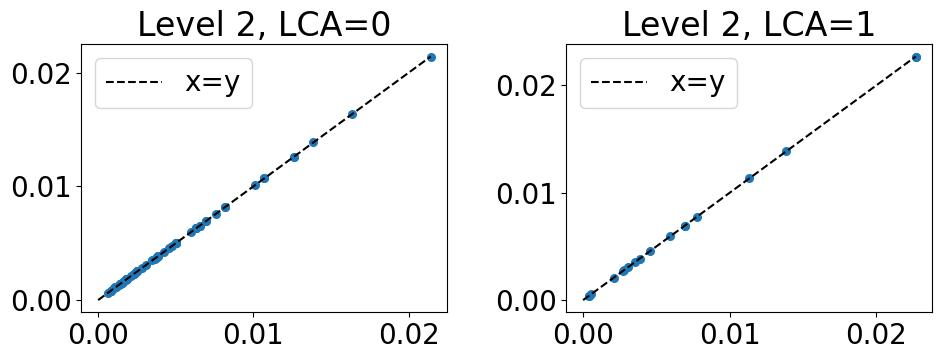

In [77]:
len(corr['normalized_pair_by_level_and_lca'][2][0])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
ax1.scatter(np.sort(corr['normalized_pair_by_level_and_lca'][2][0]), np.sort(res[0]),s=30)
ax1.plot(np.linspace(0, np.max(res[0]), 100), np.linspace(0, np.max(res[0]), 100), ls='dashed', color='k', label='x=y')
ax1.legend()
ax1.set_title('Level 2, LCA=0')

ax2.scatter(np.sort(corr['normalized_pair_by_level_and_lca'][2][1]), np.sort(res[1]),s=30)
ax2.plot(np.linspace(0, np.max(res[1]), 100), np.linspace(0, np.max(res[1]), 100), ls='dashed', color='k', label='x=y')
ax2.legend()
ax2.set_title('Level 2, LCA=1')
plt.tight_layout()